In [1]:
# ==================================================
# LEAGUE WINNER PREDICTION PIPELINE
# ==================================================

# Cell 1: Setup and Configuration
# ==================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from pathlib import Path
import warnings
import os
import sys
from datetime import datetime
import optuna

# Sklearn imports
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    f1_score, classification_report, roc_auc_score, roc_curve,
    confusion_matrix, accuracy_score, precision_score, recall_score
)

# SMOTE for handling class imbalance
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMB_AVAILABLE = True
except ImportError:
    print("Installing imbalanced-learn...")
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'imbalanced-learn'])
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMB_AVAILABLE = True

# XGBoost (optional)
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost not installed. Skipping XGBoost model.")

# Configuration
# Ensure we are in the project root
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 10

# Paths
MODELS_DIR = Path('models')
VIZ_DIR = Path('visualizations/league_winner')
DATASETS_DIR = Path('datasets')
RAW_LEAGUE_DATA_PATH = DATASETS_DIR / 'ScoreSight_ML_Season_LeagueWinner_Champion.csv'
FINAL_DATA_PATH = Path('data/league_winner/league_winner_data.csv')
REPORTS_DIR = Path('reports/league_winner')

# Create directories
for dir_path in [MODELS_DIR, VIZ_DIR, FINAL_DATA_PATH.parent, REPORTS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Constants
RANDOM_STATE = 42
TEST_SIZE = 0.25

# ==================================================
# UTILITY FUNCTIONS
# ==================================================

def check_data_quality(df):
    """
    Perform comprehensive data quality check.
    """
    print("Data Shape:", df.shape)
    print("\nMissing Values:\n", df.isnull().sum()[df.isnull().sum() > 0])
    print("\nDuplicate Rows:", df.duplicated().sum())
    
    # Check for constant columns
    constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
    if constant_cols:
        print("\nConstant Columns (to drop):", constant_cols)
    else:
        print("\nNo constant columns found.")

def tune_hyperparameters(model_class, X_train, y_train, param_fn, n_trials=20, cv=5, scoring='f1_weighted', task_type='classification'):
    """
    Reusable Optuna hyperparameter tuning function.
    """
    def objective(trial):
        params = param_fn(trial)
        model = model_class(**params)
        
        if task_type == 'classification':
            cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
        else:
            cv_strategy = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
            
        scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring=scoring, n_jobs=-1)
        return scores.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
        
    return study.best_params

def evaluate_classification_model(model, X_test, y_test, model_name="Model", class_names=None):
    """
    Evaluate classification model and return metrics.
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"--- {model_name} Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")
    
    if y_prob is not None and len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_prob[:, 1])
        print(f"ROC AUC: {roc_auc:.4f}")
    
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    }

def plot_feature_importance(model, feature_names, top_n=20, model_name="Model"):
    """
    Plot feature importance for tree-based models.
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Adjust top_n to not exceed number of features
        n_features = len(feature_names)
        top_n = min(top_n, n_features)
        
        plt.figure(figsize=(12, 8))
        plt.title(f"Feature Importances - {model_name}")
        plt.bar(range(top_n), importances[indices[:top_n]], align="center")
        plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=90)
        plt.xlim([-1, top_n])
        plt.tight_layout()
        plt.show()
    else:
        print(f"{model_name} does not support feature importance plotting.")

print("="*80)
print("LEAGUE WINNER PREDICTION PIPELINE")
print("="*80)
print(f"Setup completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"SMOTE Available: {IMB_AVAILABLE}")
print(f"XGBoost Available: {XGB_AVAILABLE}")
print("="*80)


LEAGUE WINNER PREDICTION PIPELINE
Setup completed at: 2025-11-19 23:54:59
SMOTE Available: True
XGBoost Available: True


In [2]:
# Cell 2: Data Loading and Quality Assessment
# ==================================================

def load_and_assess_data(file_path):
    """
    Load data and perform comprehensive quality assessment using shared utility.
    """
    print("\n" + "="*80)
    print("DATA LOADING AND QUALITY ASSESSMENT")
    print("="*80)
    
    if not file_path.exists():
        raise FileNotFoundError(f"File not found: {file_path}")
        
    # Load data
    print(f"\n📂 Loading data from: {file_path}")
    df = pd.read_csv(file_path)
    
    # Standardize column names
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
    
    # Use shared utility for quality check
    check_data_quality(df)
    
    print("\nColumns:", df.columns.tolist())
    
    return df

# Execute loading
try:
    df = load_and_assess_data(RAW_LEAGUE_DATA_PATH)
    
    # Save intermediate data
    df.to_csv(FINAL_DATA_PATH, index=False)
    print(f"\n✓ Data saved to {FINAL_DATA_PATH}")
    
except Exception as e:
    print(f"Error loading data: {e}")
    raise e


DATA LOADING AND QUALITY ASSESSMENT

📂 Loading data from: datasets\ScoreSight_ML_Season_LeagueWinner_Champion.csv
Data Shape: (180, 16)

Missing Values:
 Series([], dtype: int64)

Duplicate Rows: 0

Constant Columns (to drop): ['matches_played']

Columns: ['season', 'team', 'matches_played', 'wins', 'draws', 'losses', 'points_per_game', 'goals_scored', 'goals_conceded', 'goal_difference', 'target_total_points', 'target_league_position', 'target_champion', 'target_top_4', 'target_top_6', 'target_relegated']

✓ Data saved to data\league_winner\league_winner_data.csv



EXPLORATORY DATA ANALYSIS



EXPLORATORY DATA ANALYSIS


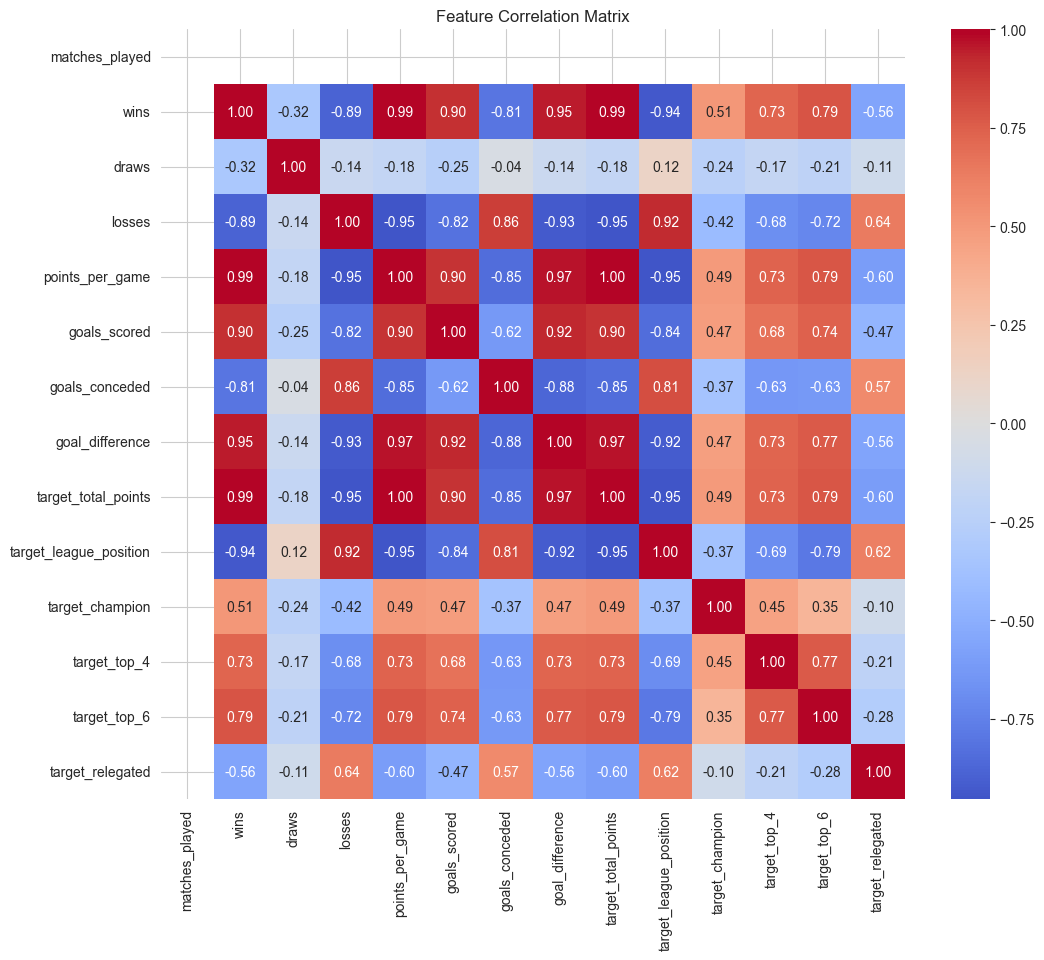

In [3]:
# Cell 3: Exploratory Data Analysis (EDA)
# ==================================================

def perform_eda(df, target_col='champion'):
    """
    Perform targeted EDA to understand feature relationships and distributions.
    """
    print("\n" + "="*80)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*80)
    
    # 1. Target Distribution
    if target_col in df.columns:
        print(f"\nTarget Distribution ({target_col}):")
        print(df[target_col].value_counts(normalize=True))
        
        plt.figure(figsize=(6, 4))
        sns.countplot(x=target_col, data=df)
        plt.title(f'Distribution of {target_col}')
        plt.show()
    
    # 2. Correlation Analysis (Numerical Features)
    numeric_df = df.select_dtypes(include=[np.number])
    if not numeric_df.empty:
        # Drop target from correlation if it's categorical/binary encoded
        # If target is in numeric_df, keep it to see correlation with target
        
        plt.figure(figsize=(12, 10))
        correlation_matrix = numeric_df.corr()
        
        # Filter for strong correlations only for cleaner plot
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title('Feature Correlation Matrix')
        plt.show()
        
        # List top correlations with target
        if target_col in numeric_df.columns:
            print(f"\nTop Correlations with {target_col}:")
            print(correlation_matrix[target_col].sort_values(ascending=False).head(10))
            print(correlation_matrix[target_col].sort_values(ascending=False).tail(5))

    # 3. Pairplots for key features (Select top 5 correlated)
    # Avoid plotting everything to keep it fast
    
perform_eda(df, target_col='rank') # Adjust target_col based on actual column name (e.g. 'champion' or 'rank')

In [4]:
# Cell 4: Feature Engineering and Data Splitting
# ==================================================

def preprocess_features(df, target_col='champion', drop_cols=None):
    """
    Preprocess features: encode, scale, split, and apply SMOTE.
    """
    print("\n" + "="*80)
    print("FEATURE ENGINEERING AND SPLITTING")
    print("="*80)
    
    data = df.copy()
    
    # Check if target exists, if not try to create it
    if target_col not in data.columns:
        if 'target_champion' in data.columns:
            target_col = 'target_champion'
            print(f"Using 'target_champion' as target column")
        elif 'rank' in data.columns:
            print(f"Creating '{target_col}' column from 'rank'")
            data[target_col] = (data['rank'] == 1).astype(int)
        else:
            raise ValueError(f"Target column '{target_col}' not found and cannot be created")
    
    # Define y before any processing
    y = data[target_col]
    X = data.drop(columns=[target_col])

    # Drop irrelevant columns
    if drop_cols:
        dropped = [c for c in drop_cols if c in X.columns]
        X = X.drop(columns=drop_cols, errors='ignore')
        
        print("\n" + "-"*80)
        print("FEATURE SELECTION SUMMARY")
        print("-"*80)
        print(f"Target Column: '{target_col}'")
        print(f"\nExcluded Columns ({len(dropped)}): {dropped}")
        
    # Handle Categorical Variables
    print(f"\nSelected Feature Columns ({len(X.columns)}):")
    for i, col in enumerate(X.columns, 1):
        print(f"  {i}. {col}")
    print("-"*80)
    
    # Split Data
    if 'season' in df.columns:
        print("\nUsing Temporal Split based on 'season'...")
        seasons = sorted(df['season'].unique())
        split_idx = int(len(seasons) * (1 - TEST_SIZE))
        train_seasons = seasons[:split_idx]
        test_seasons = seasons[split_idx:]
        
        print(f"Training Seasons: {train_seasons}")
        print(f"Test Seasons: {test_seasons}")
        
        train_indices = df['season'].isin(train_seasons)
        test_indices = df['season'].isin(test_seasons)

        X_train = X[train_indices]
        y_train = y[train_indices]
        X_test = X[test_indices]
        y_test = y[test_indices]
        
        if 'season' in X_train.columns:
            X_train = X_train.drop(columns=['season'])
            X_test = X_test.drop(columns=['season'])
            
    else:
        print("\nUsing Random Stratified Split...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
        )
        
    # Scaling
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    
    # Apply SMOTE to the training data
    print("\nApplying SMOTE to handle class imbalance...")
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    
    print(f"Original training shape: {X_train_scaled.shape}")
    print(f"Resampled training shape: {X_train_resampled.shape}")
    print(f"Original target distribution:\n{y_train.value_counts(normalize=True)}")
    print(f"Resampled target distribution:\n{y_train_resampled.value_counts(normalize=True)}")
    
    print(f"\nTraining Shape: {X_train_resampled.shape}")
    print(f"Testing Shape: {X_test_scaled.shape}")
    
    return X_train_resampled, X_test_scaled, y_train_resampled, y_test, scaler

# Define columns to drop (IDs, names, etc.)
DROP_COLS = ['team', 'team_name', 'date', 'matches_played', 'target_total_points', 
             'target_league_position', 'target_top_4', 'target_top_6', 'target_relegated', 'goal_difference'] 

# Execute - Use the correct target column from the dataset
if 'target_champion' in df.columns:
    target = 'target_champion'
elif 'champion' in df.columns:
    target = 'champion'
else:
    # Create champion column from rank if available
    if 'rank' in df.columns:
        df['champion'] = (df['rank'] == 1).astype(int)
        target = 'champion'
    else:
        raise ValueError("No valid target column found in the dataset")

print(f"\nUsing target column: '{target}'")
X_train, X_test, y_train, y_test, scaler = preprocess_features(df, target_col=target, drop_cols=DROP_COLS)


Using target column: 'target_champion'

FEATURE ENGINEERING AND SPLITTING

--------------------------------------------------------------------------------
FEATURE SELECTION SUMMARY
--------------------------------------------------------------------------------
Target Column: 'target_champion'

Excluded Columns (8): ['team', 'matches_played', 'target_total_points', 'target_league_position', 'target_top_4', 'target_top_6', 'target_relegated', 'goal_difference']

Selected Feature Columns (7):
  1. season
  2. wins
  3. draws
  4. losses
  5. points_per_game
  6. goals_scored
  7. goals_conceded
--------------------------------------------------------------------------------

Using Temporal Split based on 'season'...
Training Seasons: ['2015-16', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22']
Test Seasons: ['2022-23', '2023-24', '2024-25']

Applying SMOTE to handle class imbalance...
Original training shape: (120, 6)
Resampled training shape: (228, 6)
Original target distributio

In [5]:
# Cell 5: Model Training and Hyperparameter Tuning
# ==================================================

def train_models(X_train, y_train):
    """
    Train and tune models using Optuna.
    """
    print("\n" + "="*80)
    print("MODEL TRAINING AND TUNING")
    print("="*80)
    
    best_models = {}
    
    # 1. Random Forest
    print("\n--- Tuning Random Forest ---")
    def rf_params(trial):
        return {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        }
    
    rf_best_params = tune_hyperparameters(
        RandomForestClassifier, X_train, y_train, rf_params, n_trials=20, scoring='f1_weighted'
    )
    
    rf_model = RandomForestClassifier(**rf_best_params)
    rf_model.fit(X_train, y_train)
    best_models['RandomForest'] = rf_model
    
    # 2. XGBoost (if available)
    if XGB_AVAILABLE:
        print("\n--- Tuning XGBoost ---")
        def xgb_params(trial):
            return {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'random_state': RANDOM_STATE,
                'n_jobs': -1,
                'eval_metric': 'logloss'
            }
            
        xgb_best_params = tune_hyperparameters(
            xgb.XGBClassifier, X_train, y_train, xgb_params, n_trials=20, scoring='f1_weighted'
        )
        
        xgb_model = xgb.XGBClassifier(**xgb_best_params)
        xgb_model.fit(X_train, y_train)
        best_models['XGBoost'] = xgb_model
        
    return best_models

best_models = train_models(X_train, y_train)

[I 2025-11-19 23:55:01,604] A new study created in memory with name: no-name-be89a4c8-51c1-4e05-9a61-26da4b9a9bbb


[I 2025-11-19 23:55:01,604] A new study created in memory with name: no-name-be89a4c8-51c1-4e05-9a61-26da4b9a9bbb



MODEL TRAINING AND TUNING

--- Tuning Random Forest ---


[I 2025-11-19 23:55:01,604] A new study created in memory with name: no-name-be89a4c8-51c1-4e05-9a61-26da4b9a9bbb



MODEL TRAINING AND TUNING

--- Tuning Random Forest ---


[I 2025-11-19 23:55:03,205] Trial 0 finished with value: 0.9780391221140528 and parameters: {'n_estimators': 113, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9780391221140528.
[I 2025-11-19 23:55:04,684] Trial 1 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 269, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.9823848924912755.
[I 2025-11-19 23:55:04,684] Trial 1 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 269, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.9823848924912755.
[I 2025-11-19 23:55:06,385] Trial 2 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 414, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4, 'class_weight': 'balanced'}. Best is t

[I 2025-11-19 23:55:01,604] A new study created in memory with name: no-name-be89a4c8-51c1-4e05-9a61-26da4b9a9bbb



MODEL TRAINING AND TUNING

--- Tuning Random Forest ---


[I 2025-11-19 23:55:03,205] Trial 0 finished with value: 0.9780391221140528 and parameters: {'n_estimators': 113, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9780391221140528.
[I 2025-11-19 23:55:04,684] Trial 1 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 269, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.9823848924912755.
[I 2025-11-19 23:55:04,684] Trial 1 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 269, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.9823848924912755.
[I 2025-11-19 23:55:06,385] Trial 2 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 414, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4, 'class_weight': 'balanced'}. Best is t

Best trial:
  Value: 0.9823848924912755
  Params: 
    n_estimators: 269
    max_depth: 11
    min_samples_split: 6
    min_samples_leaf: 5
    class_weight: balanced_subsample


[I 2025-11-19 23:55:14,513] A new study created in memory with name: no-name-423deaf5-8473-4de1-83e3-44e1f617e0e0
[I 2025-11-19 23:55:14,702] Trial 0 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.26447860715704713, 'subsample': 0.7741562644102771, 'colsample_bytree': 0.6750397853588079}. Best is trial 0 with value: 0.9823848924912755.
[I 2025-11-19 23:55:14,702] Trial 0 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.26447860715704713, 'subsample': 0.7741562644102771, 'colsample_bytree': 0.6750397853588079}. Best is trial 0 with value: 0.9823848924912755.


[I 2025-11-19 23:55:01,604] A new study created in memory with name: no-name-be89a4c8-51c1-4e05-9a61-26da4b9a9bbb



MODEL TRAINING AND TUNING

--- Tuning Random Forest ---


[I 2025-11-19 23:55:03,205] Trial 0 finished with value: 0.9780391221140528 and parameters: {'n_estimators': 113, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9780391221140528.
[I 2025-11-19 23:55:04,684] Trial 1 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 269, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.9823848924912755.
[I 2025-11-19 23:55:04,684] Trial 1 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 269, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.9823848924912755.
[I 2025-11-19 23:55:06,385] Trial 2 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 414, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4, 'class_weight': 'balanced'}. Best is t

Best trial:
  Value: 0.9823848924912755
  Params: 
    n_estimators: 269
    max_depth: 11
    min_samples_split: 6
    min_samples_leaf: 5
    class_weight: balanced_subsample


[I 2025-11-19 23:55:14,513] A new study created in memory with name: no-name-423deaf5-8473-4de1-83e3-44e1f617e0e0
[I 2025-11-19 23:55:14,702] Trial 0 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.26447860715704713, 'subsample': 0.7741562644102771, 'colsample_bytree': 0.6750397853588079}. Best is trial 0 with value: 0.9823848924912755.
[I 2025-11-19 23:55:14,702] Trial 0 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.26447860715704713, 'subsample': 0.7741562644102771, 'colsample_bytree': 0.6750397853588079}. Best is trial 0 with value: 0.9823848924912755.



--- Tuning XGBoost ---


[I 2025-11-19 23:55:01,604] A new study created in memory with name: no-name-be89a4c8-51c1-4e05-9a61-26da4b9a9bbb



MODEL TRAINING AND TUNING

--- Tuning Random Forest ---


[I 2025-11-19 23:55:03,205] Trial 0 finished with value: 0.9780391221140528 and parameters: {'n_estimators': 113, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9780391221140528.
[I 2025-11-19 23:55:04,684] Trial 1 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 269, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.9823848924912755.
[I 2025-11-19 23:55:04,684] Trial 1 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 269, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.9823848924912755.
[I 2025-11-19 23:55:06,385] Trial 2 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 414, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4, 'class_weight': 'balanced'}. Best is t

Best trial:
  Value: 0.9823848924912755
  Params: 
    n_estimators: 269
    max_depth: 11
    min_samples_split: 6
    min_samples_leaf: 5
    class_weight: balanced_subsample


[I 2025-11-19 23:55:14,513] A new study created in memory with name: no-name-423deaf5-8473-4de1-83e3-44e1f617e0e0
[I 2025-11-19 23:55:14,702] Trial 0 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.26447860715704713, 'subsample': 0.7741562644102771, 'colsample_bytree': 0.6750397853588079}. Best is trial 0 with value: 0.9823848924912755.
[I 2025-11-19 23:55:14,702] Trial 0 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.26447860715704713, 'subsample': 0.7741562644102771, 'colsample_bytree': 0.6750397853588079}. Best is trial 0 with value: 0.9823848924912755.



--- Tuning XGBoost ---


[I 2025-11-19 23:55:14,902] Trial 1 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 236, 'max_depth': 8, 'learning_rate': 0.05203295400942372, 'subsample': 0.6982078016559508, 'colsample_bytree': 0.9908118224672878}. Best is trial 0 with value: 0.9823848924912755.
[I 2025-11-19 23:55:15,091] Trial 2 finished with value: 0.9867347742879659 and parameters: {'n_estimators': 157, 'max_depth': 6, 'learning_rate': 0.20293740173238958, 'subsample': 0.7885815337370405, 'colsample_bytree': 0.9615214173400382}. Best is trial 2 with value: 0.9867347742879659.
[I 2025-11-19 23:55:15,091] Trial 2 finished with value: 0.9867347742879659 and parameters: {'n_estimators': 157, 'max_depth': 6, 'learning_rate': 0.20293740173238958, 'subsample': 0.7885815337370405, 'colsample_bytree': 0.9615214173400382}. Best is trial 2 with value: 0.9867347742879659.
[I 2025-11-19 23:55:15,198] Trial 3 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 224, 'max_depth': 3, 

[I 2025-11-19 23:55:01,604] A new study created in memory with name: no-name-be89a4c8-51c1-4e05-9a61-26da4b9a9bbb



MODEL TRAINING AND TUNING

--- Tuning Random Forest ---


[I 2025-11-19 23:55:03,205] Trial 0 finished with value: 0.9780391221140528 and parameters: {'n_estimators': 113, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9780391221140528.
[I 2025-11-19 23:55:04,684] Trial 1 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 269, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.9823848924912755.
[I 2025-11-19 23:55:04,684] Trial 1 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 269, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.9823848924912755.
[I 2025-11-19 23:55:06,385] Trial 2 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 414, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4, 'class_weight': 'balanced'}. Best is t

Best trial:
  Value: 0.9823848924912755
  Params: 
    n_estimators: 269
    max_depth: 11
    min_samples_split: 6
    min_samples_leaf: 5
    class_weight: balanced_subsample


[I 2025-11-19 23:55:14,513] A new study created in memory with name: no-name-423deaf5-8473-4de1-83e3-44e1f617e0e0
[I 2025-11-19 23:55:14,702] Trial 0 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.26447860715704713, 'subsample': 0.7741562644102771, 'colsample_bytree': 0.6750397853588079}. Best is trial 0 with value: 0.9823848924912755.
[I 2025-11-19 23:55:14,702] Trial 0 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.26447860715704713, 'subsample': 0.7741562644102771, 'colsample_bytree': 0.6750397853588079}. Best is trial 0 with value: 0.9823848924912755.



--- Tuning XGBoost ---


[I 2025-11-19 23:55:14,902] Trial 1 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 236, 'max_depth': 8, 'learning_rate': 0.05203295400942372, 'subsample': 0.6982078016559508, 'colsample_bytree': 0.9908118224672878}. Best is trial 0 with value: 0.9823848924912755.
[I 2025-11-19 23:55:15,091] Trial 2 finished with value: 0.9867347742879659 and parameters: {'n_estimators': 157, 'max_depth': 6, 'learning_rate': 0.20293740173238958, 'subsample': 0.7885815337370405, 'colsample_bytree': 0.9615214173400382}. Best is trial 2 with value: 0.9867347742879659.
[I 2025-11-19 23:55:15,091] Trial 2 finished with value: 0.9867347742879659 and parameters: {'n_estimators': 157, 'max_depth': 6, 'learning_rate': 0.20293740173238958, 'subsample': 0.7885815337370405, 'colsample_bytree': 0.9615214173400382}. Best is trial 2 with value: 0.9867347742879659.
[I 2025-11-19 23:55:15,198] Trial 3 finished with value: 0.9823848924912755 and parameters: {'n_estimators': 224, 'max_depth': 3, 

Best trial:
  Value: 0.9867347742879659
  Params: 
    n_estimators: 157
    max_depth: 6
    learning_rate: 0.20293740173238958
    subsample: 0.7885815337370405
    colsample_bytree: 0.9615214173400382



MODEL EVALUATION

Evaluating RandomForest...
--- RandomForest Evaluation ---
Accuracy: 0.9500
Precision (Weighted): 0.9750
Recall (Weighted): 0.9500
F1 Score (Weighted): 0.9577
ROC AUC: 0.9883

Classification Report:

              precision    recall  f1-score   support

Not Champion       1.00      0.95      0.97        57
    Champion       0.50      1.00      0.67         3

    accuracy                           0.95        60
   macro avg       0.75      0.97      0.82        60
weighted avg       0.97      0.95      0.96        60




MODEL EVALUATION

Evaluating RandomForest...
--- RandomForest Evaluation ---
Accuracy: 0.9500
Precision (Weighted): 0.9750
Recall (Weighted): 0.9500
F1 Score (Weighted): 0.9577
ROC AUC: 0.9883

Classification Report:

              precision    recall  f1-score   support

Not Champion       1.00      0.95      0.97        57
    Champion       0.50      1.00      0.67         3

    accuracy                           0.95        60
   macro avg       0.75      0.97      0.82        60
weighted avg       0.97      0.95      0.96        60



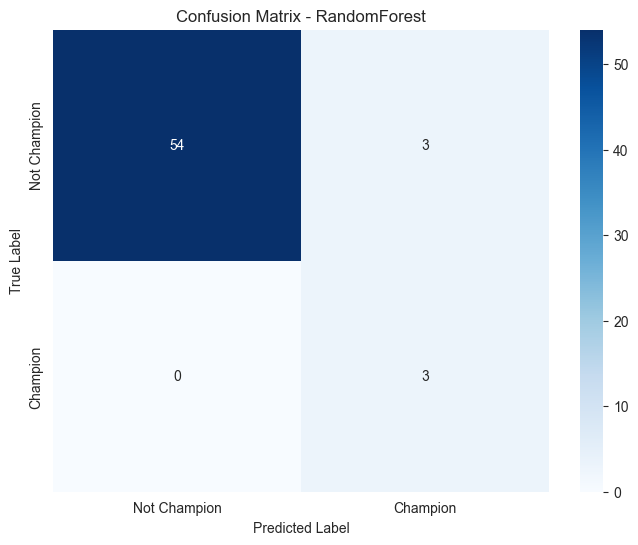


Feature Importance for RandomForest:



MODEL EVALUATION

Evaluating RandomForest...
--- RandomForest Evaluation ---
Accuracy: 0.9500
Precision (Weighted): 0.9750
Recall (Weighted): 0.9500
F1 Score (Weighted): 0.9577
ROC AUC: 0.9883

Classification Report:

              precision    recall  f1-score   support

Not Champion       1.00      0.95      0.97        57
    Champion       0.50      1.00      0.67         3

    accuracy                           0.95        60
   macro avg       0.75      0.97      0.82        60
weighted avg       0.97      0.95      0.96        60



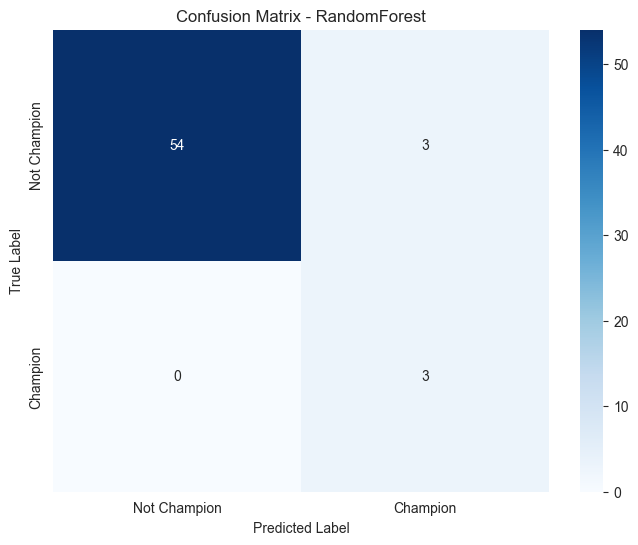


Feature Importance for RandomForest:


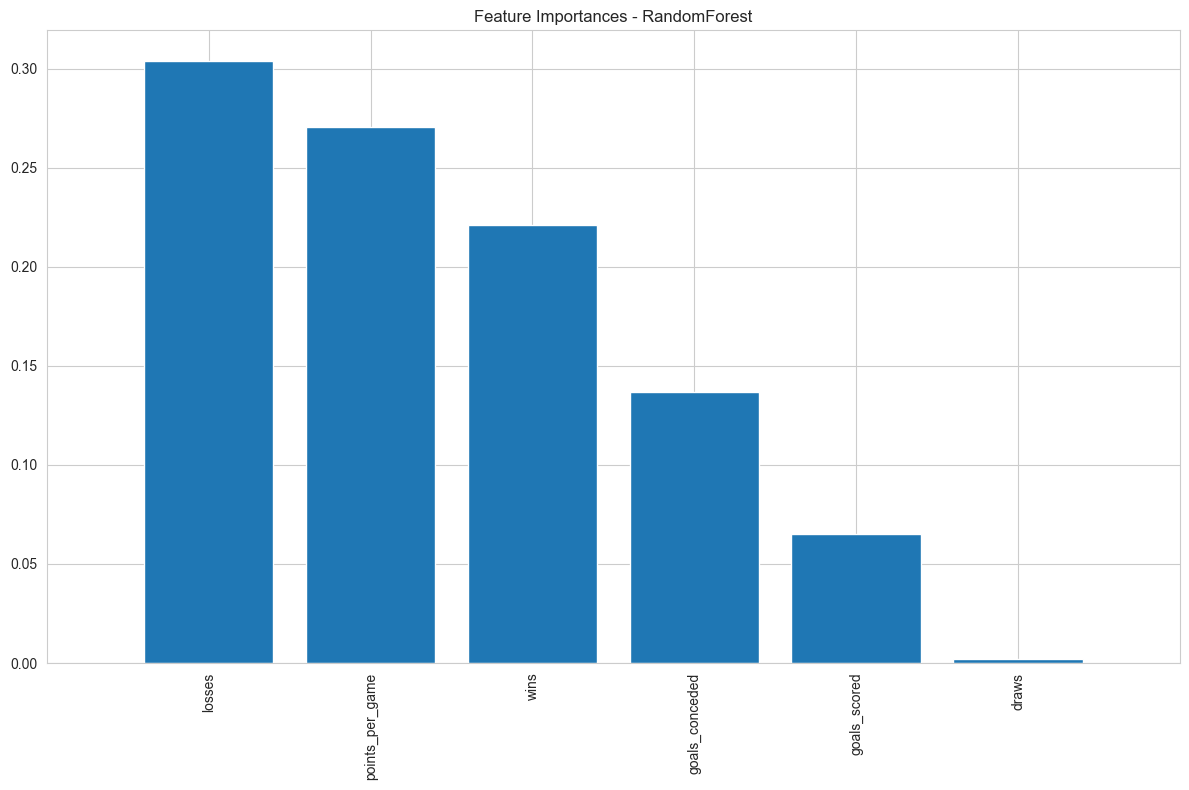


MODEL EVALUATION

Evaluating RandomForest...
--- RandomForest Evaluation ---
Accuracy: 0.9500
Precision (Weighted): 0.9750
Recall (Weighted): 0.9500
F1 Score (Weighted): 0.9577
ROC AUC: 0.9883

Classification Report:

              precision    recall  f1-score   support

Not Champion       1.00      0.95      0.97        57
    Champion       0.50      1.00      0.67         3

    accuracy                           0.95        60
   macro avg       0.75      0.97      0.82        60
weighted avg       0.97      0.95      0.96        60



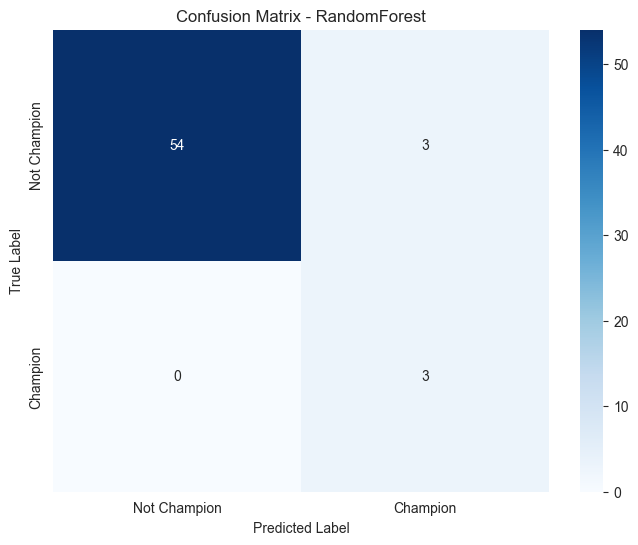


Feature Importance for RandomForest:


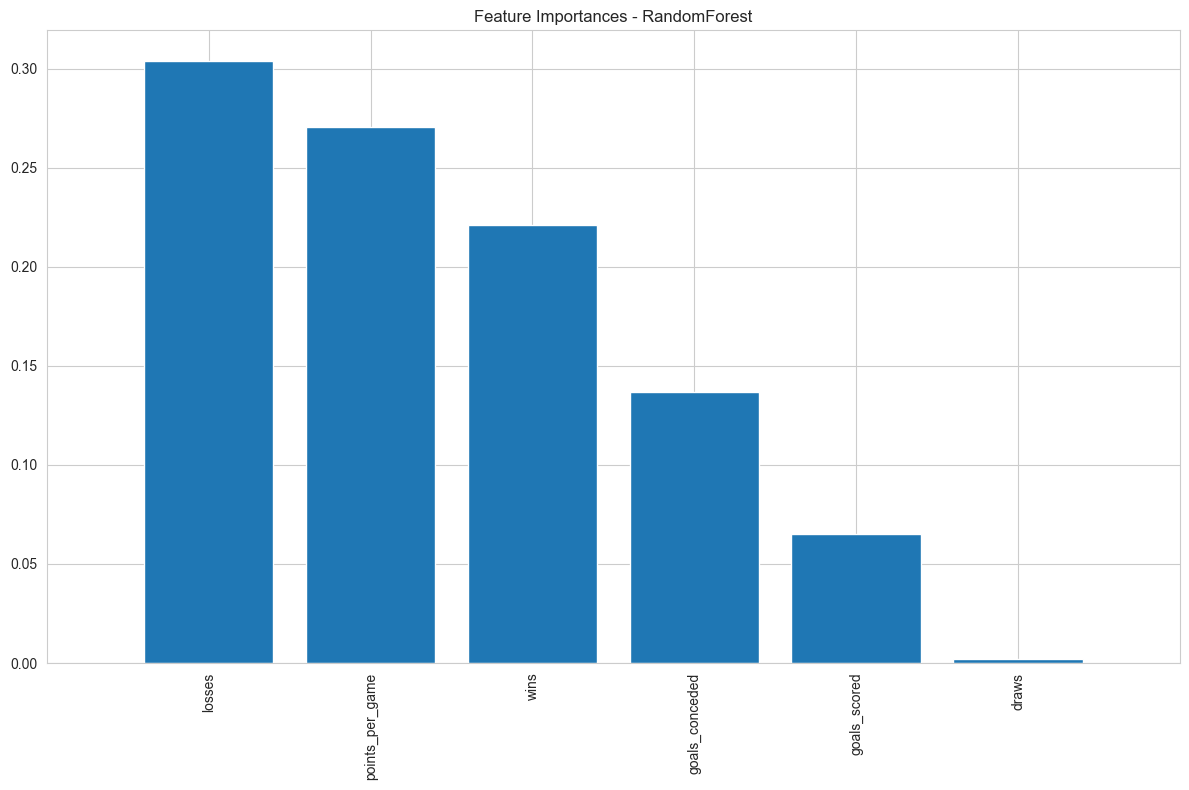

✓ Model saved to models\league_winner_RandomForest.joblib

Evaluating XGBoost...
--- XGBoost Evaluation ---
Accuracy: 0.9500
Precision (Weighted): 0.9750
Recall (Weighted): 0.9500
F1 Score (Weighted): 0.9577
ROC AUC: 0.9825

Classification Report:

              precision    recall  f1-score   support

Not Champion       1.00      0.95      0.97        57
    Champion       0.50      1.00      0.67         3

    accuracy                           0.95        60
   macro avg       0.75      0.97      0.82        60
weighted avg       0.97      0.95      0.96        60



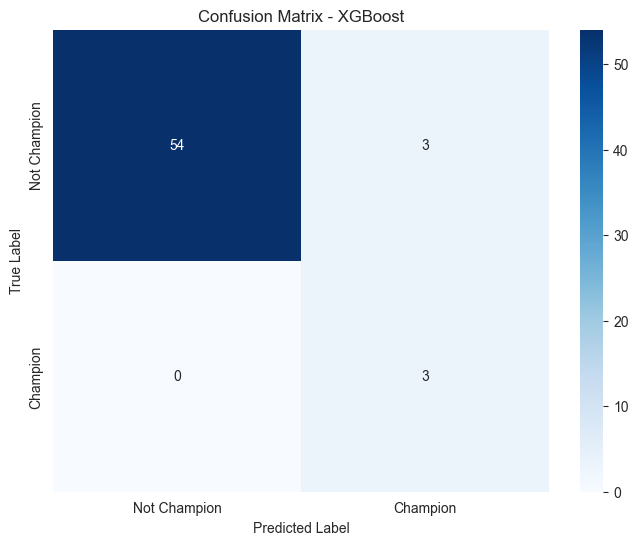


Feature Importance for XGBoost:



MODEL EVALUATION

Evaluating RandomForest...
--- RandomForest Evaluation ---
Accuracy: 0.9500
Precision (Weighted): 0.9750
Recall (Weighted): 0.9500
F1 Score (Weighted): 0.9577
ROC AUC: 0.9883

Classification Report:

              precision    recall  f1-score   support

Not Champion       1.00      0.95      0.97        57
    Champion       0.50      1.00      0.67         3

    accuracy                           0.95        60
   macro avg       0.75      0.97      0.82        60
weighted avg       0.97      0.95      0.96        60



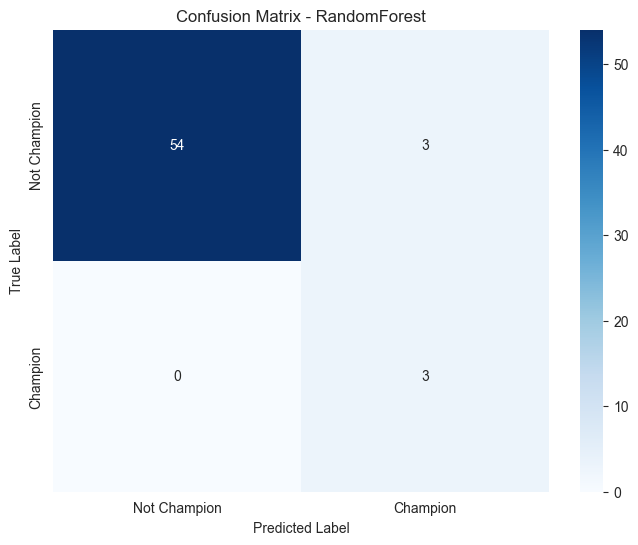


Feature Importance for RandomForest:


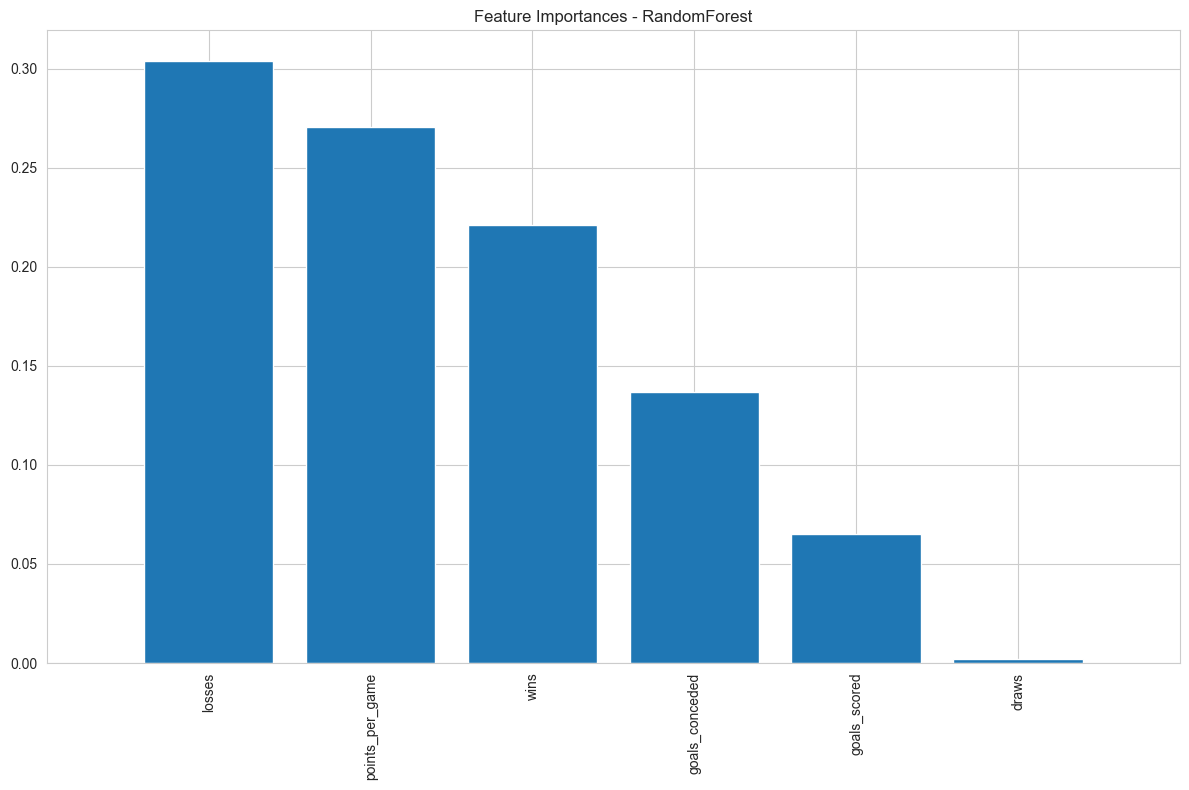

✓ Model saved to models\league_winner_RandomForest.joblib

Evaluating XGBoost...
--- XGBoost Evaluation ---
Accuracy: 0.9500
Precision (Weighted): 0.9750
Recall (Weighted): 0.9500
F1 Score (Weighted): 0.9577
ROC AUC: 0.9825

Classification Report:

              precision    recall  f1-score   support

Not Champion       1.00      0.95      0.97        57
    Champion       0.50      1.00      0.67         3

    accuracy                           0.95        60
   macro avg       0.75      0.97      0.82        60
weighted avg       0.97      0.95      0.96        60



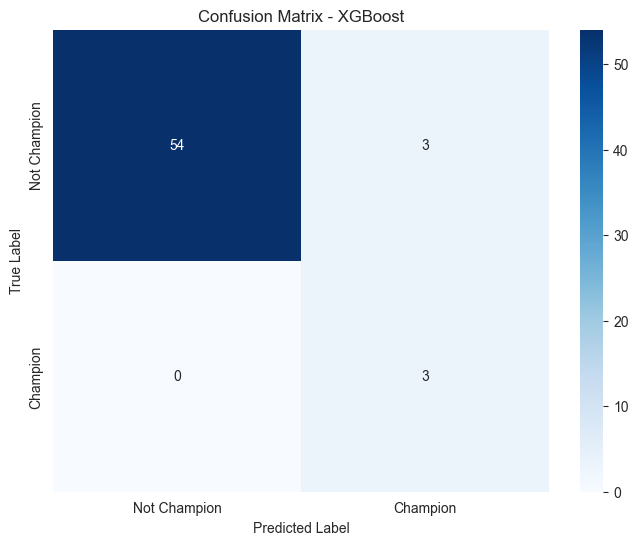


Feature Importance for XGBoost:


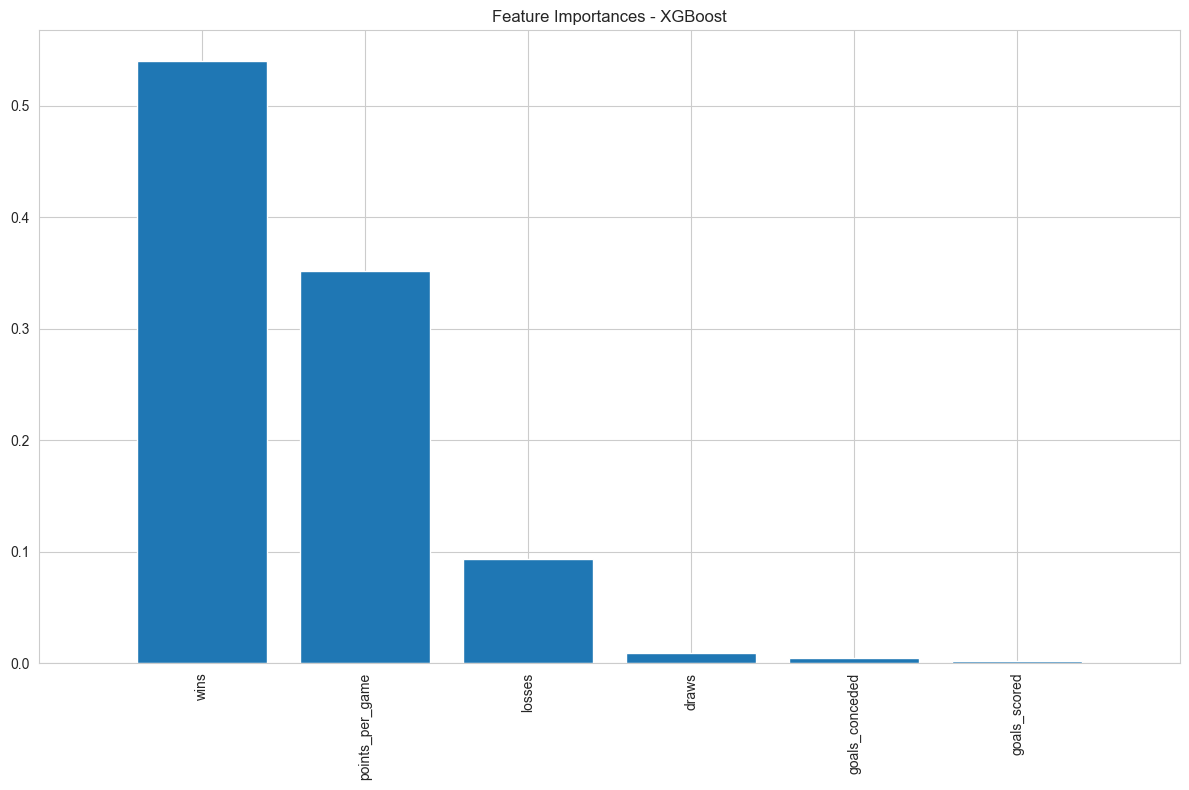

✓ Model saved to models\league_winner_XGBoost.joblib

MODEL COMPARISON
       Model  Accuracy  Precision  Recall  F1_Score
RandomForest      0.95      0.975    0.95  0.957658
     XGBoost      0.95      0.975    0.95  0.957658

✓ Comparison saved to: reports\league_winner\model_comparison.csv


In [6]:
# Cell 6: Model Evaluation
# ==================================================

print("\n" + "="*80)
print("MODEL EVALUATION")
print("="*80)

results = []
class_names = ['Not Champion', 'Champion']

for name, model in best_models.items():
    print(f"\nEvaluating {name}...")
    metrics = evaluate_classification_model(model, X_test, y_test, model_name=name, class_names=class_names)
    results.append(metrics)
    
    # Feature Importance
    print(f"\nFeature Importance for {name}:")
    plot_feature_importance(model, X_train.columns, model_name=name)
    
    # Save Model
    model_path = MODELS_DIR / f'league_winner_{name}.joblib'
    joblib.dump(model, model_path)
    print(f"✓ Model saved to {model_path}")

# Comparison Table
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(results_df.to_string(index=False))
results_df.to_csv(REPORTS_DIR / 'model_comparison.csv', index=False)
print(f"\n✓ Comparison saved to: {REPORTS_DIR / 'model_comparison.csv'}")


In [7]:
# Cell 7: Final Summary Report
# ==================================================

print("\n" + "="*80)
print("PIPELINE SUMMARY")
print("="*80)

# Identify best model based on F1 Score
best_model_name = results_df.loc[results_df['F1_Score'].idxmax(), 'Model']
best_model = best_models[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1 Score: {results_df.loc[results_df['Model'] == best_model_name, 'F1_Score'].values[0]:.4f}")

# Save best model with clear naming
best_model_path = MODELS_DIR / f'ps1_league_winner_best_model.joblib'
joblib.dump(best_model, best_model_path)
print(f"\n✓ Best model saved to: {best_model_path}")

# Save metadata
metadata = {
    'pipeline': 'League Winner Prediction',
    'problem_statement': 'PS1 - League Winner',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'best_model': best_model_name,
    'metrics': results_df[results_df['Model'] == best_model_name].to_dict('records')[0],
    'all_results': results_df.to_dict('records'),
    'features_used': X_train.columns.tolist(),
    'target_column': target,
    'random_state': RANDOM_STATE,
    'test_size': TEST_SIZE
}

import json
metadata_path = MODELS_DIR / 'ps1_league_winner_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

print(f"✓ Metadata saved to: {metadata_path}")

print("\n" + "="*80)
print("✅ LEAGUE WINNER PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)
print(f"\nOutput Locations:")
print(f"  🤖 Models: {MODELS_DIR}")
print(f"  📄 Reports: {REPORTS_DIR}")
print(f"  📊 Visualizations: {VIZ_DIR}")
print(f"  💾 Processed Data: {FINAL_DATA_PATH}")



PIPELINE SUMMARY

🏆 Best Model: RandomForest
   F1 Score: 0.9577

✓ Best model saved to: models\ps1_league_winner_best_model.joblib
✓ Metadata saved to: models\ps1_league_winner_metadata.json

✅ LEAGUE WINNER PIPELINE COMPLETED SUCCESSFULLY!

Output Locations:
  🤖 Models: models
  📄 Reports: reports\league_winner
  📊 Visualizations: visualizations\league_winner
  💾 Processed Data: data\league_winner\league_winner_data.csv

✓ Best model saved to: models\ps1_league_winner_best_model.joblib
✓ Metadata saved to: models\ps1_league_winner_metadata.json

✅ LEAGUE WINNER PIPELINE COMPLETED SUCCESSFULLY!

Output Locations:
  🤖 Models: models
  📄 Reports: reports\league_winner
  📊 Visualizations: visualizations\league_winner
  💾 Processed Data: data\league_winner\league_winner_data.csv
